In [1]:
import math

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.random
import pandas as pd

from utils import compute_influences, slice_dataset, compute_avg_influences

In [2]:
# Parameters

dataset = 'ht09_contact'

beta = 0.5
phi = 0.2

# TODO: Should be chosen based on the dataset
delta_t = 500

# Same here, probably?
k = 5

In [3]:
# Load the dataset into a DataFrame.
data: pd.DataFrame = pd.read_csv(f"../data/{dataset}.txt", sep="\t", header=None, names=["source", "target", "ts"])

# Get unique timestamps.
timestamps = data["ts"].unique()

# Remap timestamps to remove gaps.
# This makes the timestamps equvivalent to range(len(timestamps)),
# which allows us to do `for t in range(t0, round(phi*delta_t) + 1)` effortlessly.
ts_mapping = {}
r = range(len(timestamps))
for i, t in enumerate(timestamps):
    if t != r[i]:
        ts_mapping[t] = i

data["ts"].replace(to_replace=ts_mapping, inplace=True)

timestamps = data["ts"].unique()

# Construct graph from DataFrame, specifying MultiGraph and timestamp as edge attribute.
graph: nx.MultiGraph = nx.from_pandas_edgelist(data, create_using=nx.MultiGraph, edge_attr="ts", edge_key="ts")

In [19]:
rng = numpy.random.default_rng(1337)


num_time_windows = 2
iters = 5
labels = [
    'Number of nodes within k hops in [t_0, t_0 + phi*Delta_T]',
    'Number of total contacts k hops in [t_0, t_0 + phi*Delta_T]',
    'Degree Centrality',
    'Closeness Centrality',
    'Betweenness Centrality',
    'Harmonic Centrality',
]

X = []
y = []
t0s = rng.choice(len(timestamps), num_time_windows, replace=False)

for t0 in t0s:
    # Compute the influences for all nodes and ranking order
    node_influences, node_ranking = compute_avg_influences(graph, t0, delta_t, beta, iters, rng)

    # Create subgraph of [t0, t0 + delta_t*phi]
    sub_data = slice_dataset(data, t0, delta_t, phi)
    aggregated_sub_data = sub_data.drop(columns=["ts"])
    aggregated_sub_graph: nx.Graph = nx.from_pandas_edgelist(aggregated_sub_data)

    # Preallocate a matrix for all the metrics, default is 0
    metrics = np.zeros((len(graph.nodes), len(labels)))
    # For every node that is present in the subgraph
    for node in graph.nodes:
        if node in aggregated_sub_graph:
            # Find all the nodes within k hops from our source node
            nodes_within_k_hops = nx.single_source_shortest_path(aggregated_sub_graph, node, cutoff=k),
            # (single_source_shortest_path is supposed to return a dict but sometimes it returns a tuple,
            # so we're unpacking it if that's the case ...)
            if type(nodes_within_k_hops) is tuple:
                (nodes_within_k_hops,) = nodes_within_k_hops
            # Create a smaller subgraph from the original, which only includes those nodes that are
            # accessible within k hops
            subgraph = nx.induced_subgraph(aggregated_sub_graph, nodes_within_k_hops.keys()),
            # (same here...)
            if type(subgraph) is tuple:
                (subgraph,) = subgraph
            # Compute the metrics in the node in this subgraph
            if node in subgraph.nodes:
                # The -1 in the indexing is because nx uses 1-indexing for the nodes and numpy is 0-idx
                metrics[node - 1][:] = [
                    len(nodes_within_k_hops),
                    sum((len(conns) for conns in nodes_within_k_hops.values())),
                    nx.degree_centrality(subgraph)[node],
                    nx.closeness_centrality(subgraph, node),
                    nx.betweenness_centrality(subgraph)[node],
                    nx.harmonic_centrality(subgraph)[node],
                ]

    # Scale them all to 0-1
    metrics -= metrics.min(axis=0)
    max = metrics.max(axis=0)
    max[max == 0] = 10**-5
    metrics /= max

    # keep track of the values from the subgraph (X) and the values we want to predict (actually,
    # the ranking of nodes that these cause) in two lists, which we'll merge into one matrix later.
    X.append(metrics)
    y.append(node_influences)

X = np.array(X)
y = np.array(y)
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

In [ ]:
from sklearn.model_selection import train_test_split

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

0.31991941928204026


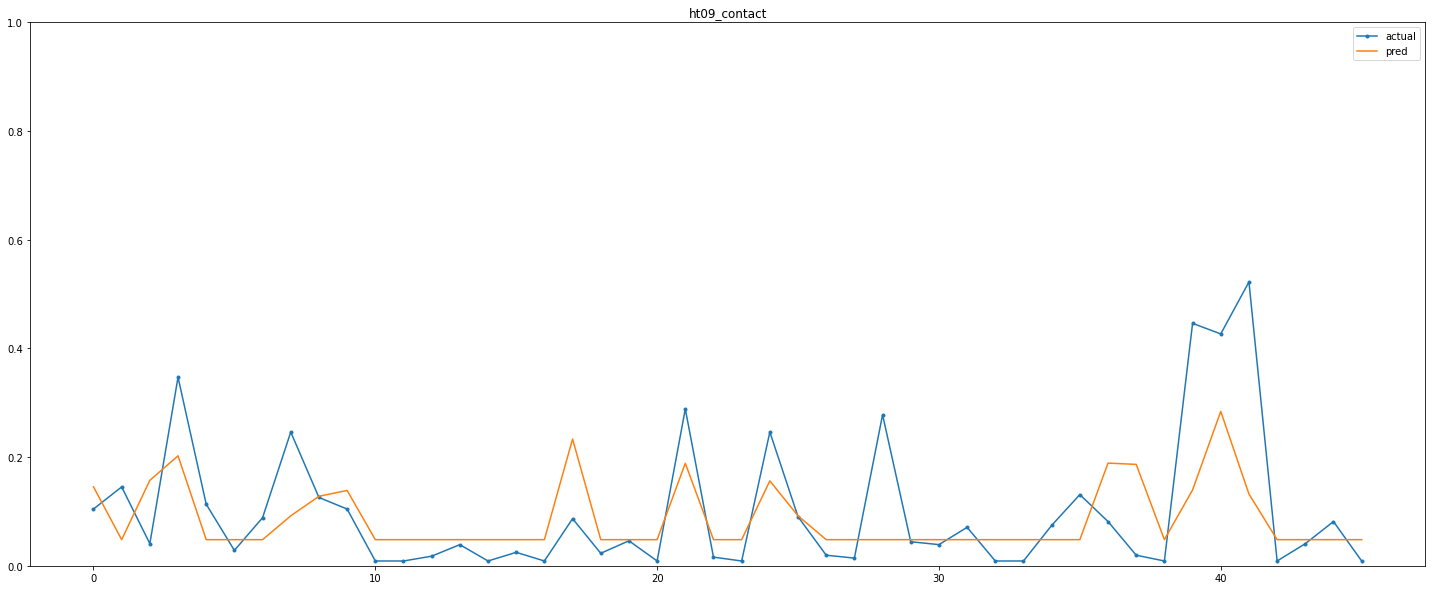

In [39]:
# Try a linear reg
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)
print(reg.score(X_test, y_test))

fig, ax1 = plt.subplots(figsize=(25, 10))
x = np.arange(len(y_test))
ax1.plot(x, y_test, '.-', label='actual')
ax1.plot(x, y_pred, label='pred')
ax1.set_ylim([0, 1])
plt.title(dataset)
plt.legend()

In [47]:
# Check the rankings by mean square of differences of the indices from the argsorts
y_test_ranking = y_test.argsort()
y_pred_ranking = y_pred.argsort()

np.mean((y_test_ranking - y_pred_ranking)**2)

374.30434782608694

1.0


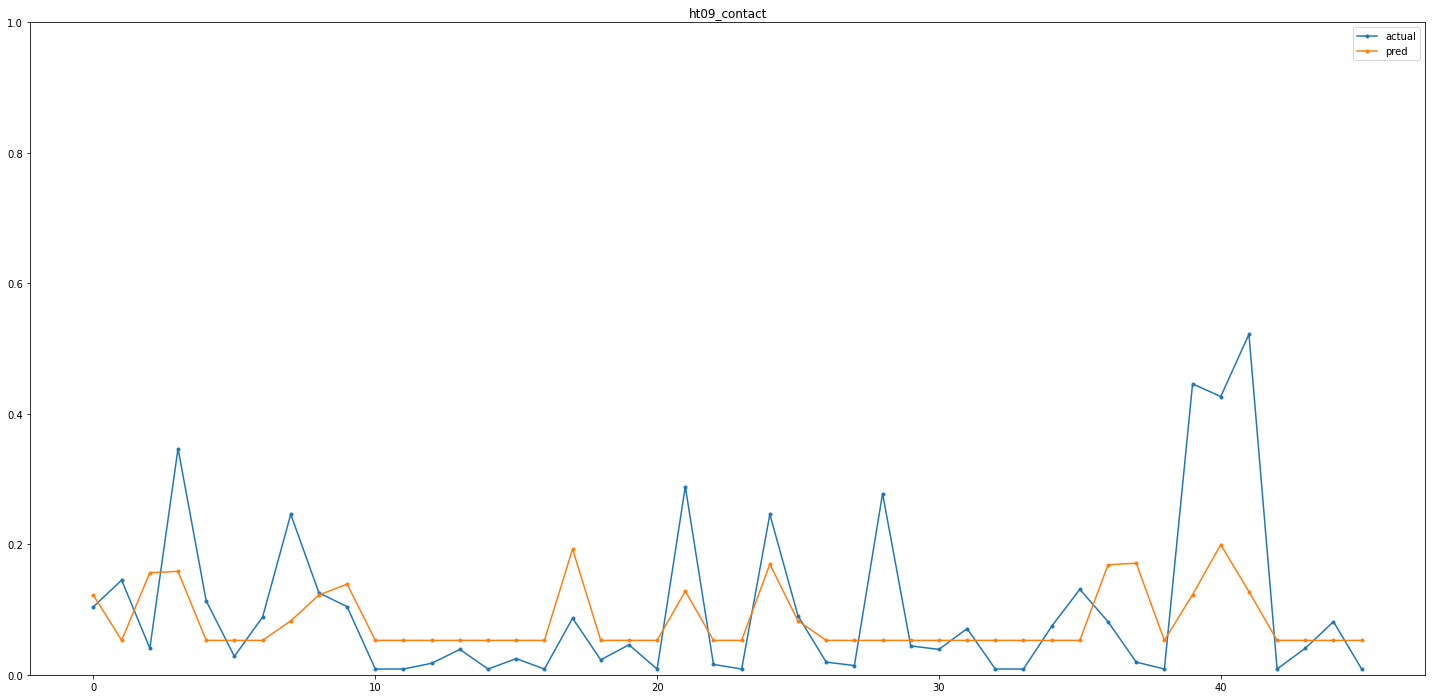

In [90]:
# Let's try a nn

from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(alpha=1e-5, max_iter=200, hidden_layer_sizes=(100,100,100,50,50,50), random_state=1)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
# y_pred = np.random.uniform(size=len(y_test))
print(reg.score(X_test, y_pred))

fig, ax1 = plt.subplots(figsize=(25, 12))
x = np.arange(len(y_test))
ax1.plot(x, y_test, '.-', label='actual')
ax1.plot(x, y_pred, '.-', label='pred')
ax1.set_ylim([0, 1])
plt.title(dataset)
plt.legend()

In [91]:
# Check again
y_test_ranking = y_test.argsort()
y_pred_ranking = y_pred.argsort()

np.mean((y_test_ranking - y_pred_ranking)**2)

279.2608695652174